In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
num_point = 1000
vectors_set = []

for i in range(num_point):
    if np.random.random() > 0.5:
        vectors_set.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    else:
        vectors_set.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])


In [63]:
df = pd.DataFrame({"x":[v[0] for v in vectors_set], "y":[v[1] for v in vectors_set]})

## 데이터를 그래프로 표현하는 여러가지 방법

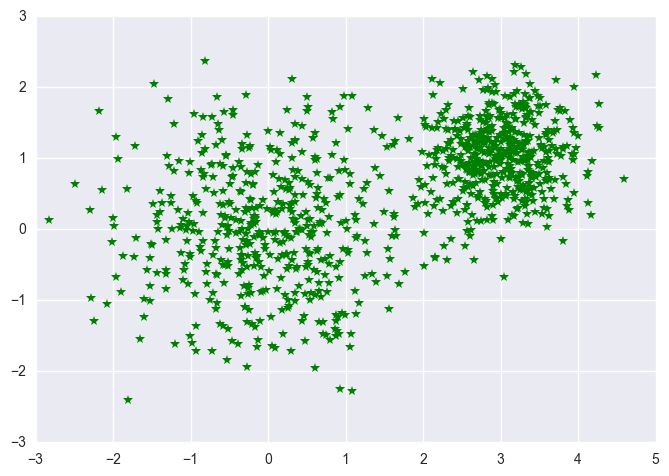

In [64]:
plt.plot(df['x'], df['y'], 'g*')
plt.show()

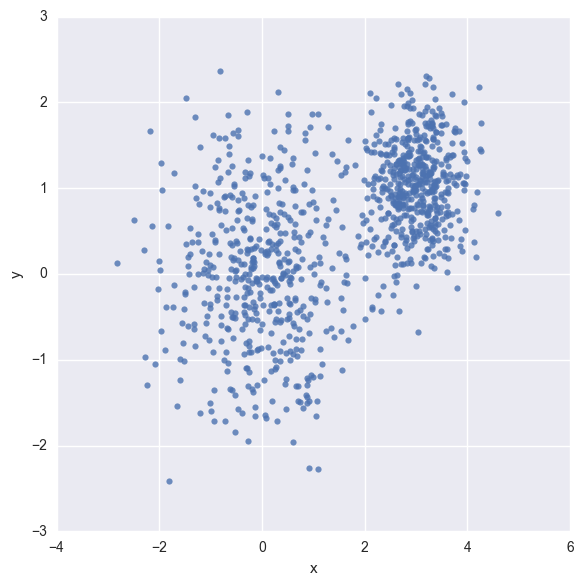

In [65]:
sns.lmplot("x", "y", data=df, fit_reg=False, size=6)
plt.show()

In [66]:
import tensorflow as tf

In [67]:
vectors = tf.constant(vectors_set)
k = 4 #  k 개의 군집으로 나누겠다
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [k,-1]))

In [68]:
print(vectors.get_shape())
print(centroides.get_shape())

(1000, 2)
(4, 2)


In [69]:
expanded_vectors = tf.expand_dims(vectors, 0) # 0번쨰 차원을 하나더 늘림
expanded_centroides = tf.expand_dims(centroides, 1) # 1번째 차원을 하나 더 늘림. 늘렸을때 크기를 모르기 때문에 사이즈는 1 이 된다

In [70]:
expanded_vectors.get_shape()

TensorShape([Dimension(1), Dimension(1000), Dimension(2)])

In [71]:
expanded_centroides.get_shape()

TensorShape([Dimension(4), Dimension(1), Dimension(2)])

### 텐서플로의 브로드 캐스팅 기능 때문에 tf.sub 함수는 크기가 1인 차원은 텐서 연산  시 다른 텐서의 해당 차원의 크기에 맞게 계산을 반복하므로 마치 차원이 늘어난 듯 한 효과를 갖는다
* 차원 D0 는 expand_centroids 는 크기가 4이고, expanded_vectors 는 1이다. 이럴때는 1이 4로 늘어나서 뺄셈을 진행하게 된다
* 차원 D1 도 마찬가지로 1인 차원이 그렇지 않은 차원으로 늘어나서 작업이 된다.

In [72]:
diff = tf.sub(expanded_vectors, expanded_centroides)
diff.get_shape()

TensorShape([Dimension(4), Dimension(1000), Dimension(2)])

In [73]:
sqr = tf.square(diff)
sqr.get_shape()

TensorShape([Dimension(4), Dimension(1000), Dimension(2)])

In [74]:
distances = tf.reduce_sum(sqr, 2) # 여기서 두번째 인자의 역할은 D2 차원을 없앤다
distances.get_shape()

TensorShape([Dimension(4), Dimension(1000)])

In [75]:
assignments = tf.argmin(distances, 0) # 어느 중신에 속하는 것이 가장 유클리드 거리상 짦은지를 판단하여 리턴한다
assignments.get_shape()

TensorShape([Dimension(1000)])

## 새로운 중심 계산하기

### 마지막은 수정 단계
### 이 알고리즘에서는 매 반복마다 새롭게 그룹화를 하면서 각 그룹에 해당하는 새로운 중심을 다시 계산한다

* equal 함수를 이용해서 한 군집과 매칭되는 assignments 텐서의 각 원소 위치를 True 로 표시하는 불리언 텐서 를 만든다
* where 함수를 이용해서 매개변수로 받은 불리언 텐서에서 True 로 표시된 위치를 값으로 가지는 텐서 를 만든다
* reshape 함수를 이용해서 c 군집에 속한 vectors 텐서의 포인트들의 인덱스로 구성된 텐서 를 만든다
* gather 함수를 이용해서 c 군집을 이루는 점들의 좌표를 모은 텐서 를 만든다
* reduce_mean 함수를 이용해서 c 군집에 속한 모든 점들의 평균 값을 가진 텐서 를 만든다

In [76]:
means = tf.concat(0, [tf.reduce_mean(tf.gather(vectors, 
                                    tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])), 
                                    reduction_indices=[1]) for c in range(k)])

## 그래프 실행
### 중심을 means 텐서의 새 값으로 업데이트 하는 코드를 살펴본다

In [77]:
update_centroides = tf.assign(centroides, means)

In [84]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(100):
        _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])
        # print(centroid_values)

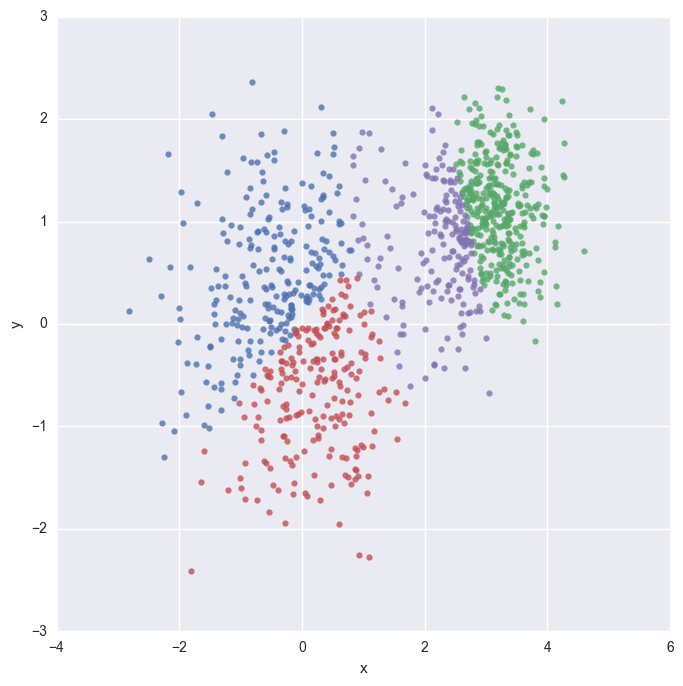

In [83]:
data = {"x":[], "y":[], "group":[]}

for i in range(len(assignment_values)):
    data['x'].append(vectors_set[i][0])
    data['y'].append(vectors_set[i][1])
    data['group'].append(assignment_values[i])
    
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, size=7, hue='group', legend=False)
plt.show()